# 专题：朴素贝叶斯分类

朴素贝叶斯模型是一组非常简单快速的分类算法，通常适用于维度非常高的数据集。因为运行速度快，而且可调参数少，因此非常适合为分类问题提供快速粗糙的基本方案。  
本节重点介绍朴素贝叶斯分类器（`naive Bayes classifiers`）的工作原理，并通过一些示例演示朴素贝叶斯分类器在经典数据集上的应用。

## 1. 贝叶斯分类

朴素贝叶斯分类器建立在贝叶斯分类方法的基础上，其数学基础是贝叶斯定理（`Bayes's theorem`）——一个描述统计量条件概率关系的公式。  
在贝叶斯分类中，我们希望确定一个具有某些特征的样本属于某类标签的概率，通常记为 `P(L|特征 )`。  
贝叶斯定理告诉我们，可以直接用下面的公式计算这个概率：  
![BayesianFormula1.png](../data/figures/BayesianFormula1.png)  
假如需要确定两种标签，定义为 `L1` 和 `L2`，一种方法就是计算这两个标签的后验概率的比值：  
![BayesianFormula2.png](../data/figures/BayesianFormula2.png)  
现在需要一种模型，帮我们计算每个标签的 `P(特征|Li)`。这种模型被称为**生成模型**，因为它可以训练出生成输入数据的假设随机过程（或称为概率分布）。  
为每种标签设置生成模型是贝叶斯分类器训练过程的主要部分。虽然这个训练步骤通常很难做，但是我们可以通过对模型进行随机分布的假设，来简化训练工作。

之所以称为“朴素”或“朴素贝叶斯”，是因为如果对每种标签的生成模型进行非常简单的假设，就能找到每种类型生成模型的近似解，然后就可以使用贝叶斯分类。  
不同类型的朴素贝叶斯分类器是由对数据的不同假设决定的，下面将介绍一些示例来进行演示。首先导入需要用的程序库：

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## 2. 高斯朴素贝叶斯

最容易理解的朴素贝叶斯分类器可能就是高斯朴素贝叶斯（`Gaussian naive Bayes`）了，这个分类器假设**每个标签的数据都服从简单的高斯分布**。  
假如你有下面的数据，如下图所示：

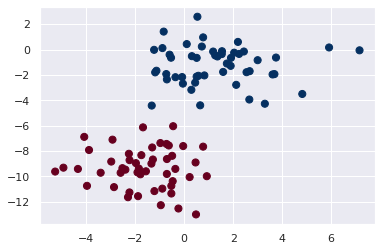

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')

一种快速创建简易模型的方法就是假设数据服从高斯分布，且变量无协方差（`no covariance`，指线性无关）。  
只要找出每个标签的所有样本点均值和标准差，再定义一个高斯分布，就可以拟合模型了。  
这个简单的高斯假设分类的结果如下图所示：  
![](../data/figures/05.05-gaussian-NB.png)

图中的椭圆曲线表示每个标签的高斯生成模型，越靠近椭圆中心的可能性越大。  
通过每种类型的生成模型，可以计算出任意数据点的似然估计（`likelihood`） `P(特征|L1)`，然后根据贝叶斯定理计算出后验概率比值，从而确定每个数据点可能性最大的标签。

(-5.890554373486014,
 7.777566725032841,
 -13.775943665162341,
 3.3634536696825847)

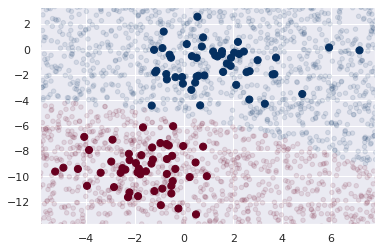

In [3]:
# 该步骤在 Scikit-Learn 的 sklearn.naive_bayes.GaussianNB 评估器中实现：
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X, y)

# 现在生成一些新数据来预测标签：
rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)
ynew = model.predict(Xnew)

# 可以将这些新数据画出来，看看决策边界的位置，如下图所示：
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.1)
plt.axis(lim)

# 可以在分类结果中看到一条稍显弯曲的边界——通常，高斯朴素贝叶斯的边界是二次方曲线。

贝叶斯主义（`Bayesian formalism`）的一个优质特性是它天生支持概率分类，我们可以用 `predict_proba` 方法计算样本属于某个标签的概率：

In [4]:
yprob = model.predict_proba(Xnew)
yprob[-8:].round(2)

array([[0.89, 0.11],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.15, 0.85]])

这个数组分别给出了前两个标签的后验概率。如果你需要评估分类器的不确定性，那么这类贝叶斯方法非常有用。  
当然，由于分类的最终效果只能依赖于一开始的模型假设，因此高斯朴素贝叶斯经常得不到非常好的结果。  
但是，在许多场景中，尤其是特征较多的时候，这种假设并不妨碍高斯朴素贝叶斯成为一种有用的方法。

## 3. 多项式朴素贝叶斯

前面介绍的高斯假设并不意味着每个标签的生成模型只能用这一种假设。还有一种常用的假设是多项式朴素贝叶斯（`multinomial naive Bayes`），它假设特征是由一个简单多项式分布生成的。  
多项分布可以描述各种类型样本出现次数的概率，因此多项式朴素贝叶斯非常适合用于描述出现次数或者出现次数比例的特征。  
这个理念和前面介绍的一样，只不过模型数据的分布不再是高斯分布，而是用多项式分布代替而已。

### 3.1. 案例：文本分类

多项式朴素贝叶斯通常用于文本分类，其特征都是指待分类文本的单词出现次数或者频次。  
这里用 20 个网络新闻组语料库（20 Newsgroups corpus，约 20 000 篇新闻）的单词出现次数作为特征，演示如何用多项式朴素贝叶斯对这些新闻组进行分类。

In [5]:
# 首先，下载数据并看看新闻组的名字：
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()  # 数据备份在 ../data/sklearn_20newsgroups.csv.bz2
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [6]:
# 为了简化演示过程，只选择四类新闻，下载训练集和测试集：
categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

In [7]:
# 选其中一篇新闻看看：
print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



Text(89.18, 0.5, 'predicted label')

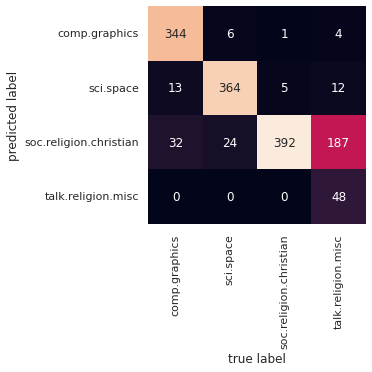

In [8]:
# 为了让这些数据能用于机器学习，需要将每个字符串的内容转换成数值向量。可以创建一个管道，将 TF–IDF 向量化方法与多项式朴素贝叶斯分类器组合在一起：
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

# 通过这个管道，就可以将模型应用到训练数据上，预测出每个测试数据的标签：
model.fit(train.data, train.target)
labels = model.predict(test.data)

# 这样就得到每个测试数据的预测标签，可以进一步评估评估器的性能了。
# 例如，用混淆矩阵统计测试数据的真实标签与预测标签的结果，如下图所示：
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

# 从图中可以明显看出，虽然用如此简单的分类器可以很好地区分关于宇宙的新闻和关于计算机的新闻，但是宗教新闻和基督教新闻的区分效果却不太好。可能是这两个领域本身就容易令人混淆！

但现在我们有一个可以对**任何**字符串进行分类的工具了，只要用管道的 `predict()` 方法就可以预测。  
下面的函数可以快速返回字符串的预测结果：

In [9]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

下面试试模型预测效果：

In [10]:
predict_category('sending a payload to the ISS')

'sci.space'

In [11]:
predict_category('discussing islam vs atheism')

'soc.religion.christian'

In [12]:
predict_category('determining the screen resolution')

'comp.graphics'

虽然这个分类器不会比直接用字符串内单词（加权的）频次构建的简易概率模型更复杂，但是它的分类效果却非常好。  
由此可见，即使是一个非常简单的算法，只要能合理利用并进行大量高维数据训练，就可以获得意想不到的效果。

## 4. 朴素贝叶斯的应用场景

由于朴素贝叶斯分类器对数据有严格的假设，因此它的训练效果通常比复杂模型的差。其优点主要体现在以下四个方面。
- 训练和预测的速度非常快。
- 直接使用概率预测。
- 通常很容易解释。
- 可调参数（如果有的话）非常少。

这些优点使得朴素贝叶斯分类器通常很适合作为分类的初始解。如果分类效果满足要求，那么万事大吉，你获得了一个非常快速且容易解释的分类器。  
但如果分类效果不够好，那么你可以尝试更复杂的分类模型，与朴素贝叶斯分类器的分类效果进行对比，看看复杂模型的分类效果究竟如何。  
朴素贝叶斯分类器非常适合用于以下应用场景。
- 假设分布函数与数据匹配（实际中很少见）。
- 各种类型的区分度很高，模型复杂度不重要。
- 非常高维度的数据，模型复杂度不重要。

后面两条看似不同，其实彼此相关：随着数据集维度的增加，任何两点都不太可能逐渐靠近（毕竟它们得在**每一个维度**上都足够接近才行）。  
也就是说，在新维度会增加样本数据信息量的假设条件下，高维数据的簇中心点比低维数据的簇中心点更分散。  
因此，随着数据维度不断增加，像朴素贝叶斯这样的简单分类器的分类效果会和复杂分类器一样，甚至更好——只要你有足够的数据，简单的模型也可以非常强大。